# 6.4 ESA Task 6.4 Supervised machine learning: regression

## Table of Contents

#### 01. Import libraries and datasets

#### 02. Verify dataset import results

#### 03. Data sourcing and prep work

#### 04. Data cleaning

#### 05. Data prep for regression analysis

#### 06. Null hypothesis

#### 07. Regression analysis

#### 08. Regression fit to a longer cycle temporal dataset for comparison

### 01. Import libraries and datasets

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# This option ensures that plots created are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [18]:
# Import dataset

path = 'C:/Users/dirk8/OneDrive/Desktop/CF/IMMERSION/EXERCISE 6.4'

df = pd.read_excel(os.path.join(path, 'aus_stock_idx_vs_audjpy.xlsx'))

### 02. Verify dataset import results

In [21]:
df.shape

(5120, 6)

In [23]:
df.columns

Index(['timestamp', 'stock_index', 'aud_jpy', 'stock_idx_log_return1',
       'aud_jpy_log_return1', 'shock_name'],
      dtype='object')

In [25]:
df.head(3)

,timestamp,stock_index,aud_jpy,stock_idx_log_return1,aud_jpy_log_return1,shock_name
0,2005-01-05,74.509804,80.092864,-0.004742,0.000103,No Shock
1,2005-01-06,74.334569,79.762383,-0.002355,-0.004135,No Shock
2,2005-01-07,74.948813,79.746651,0.008229,-0.000197,No Shock


In [27]:
df.tail(3)

,timestamp,stock_index,aud_jpy,stock_idx_log_return1,aud_jpy_log_return1,shock_name
5117,2025-03-27,147.182410,95.204104,0.000138,0.003018,Rus_Ukr_War & BOJ Pivot
5118,2025-03-28,147.094793,94.455849,-0.000595,-0.007891,Rus_Ukr_War & BOJ Pivot
5119,2025-03-31,145.727040,93.681823,-0.009342,-0.008228,Rus_Ukr_War & BOJ Pivot


### 03. Data sourcing and prep work

#### Data sourcing: the Task 6.4 is to run a single-variable linear regression and evaluate the results. Since the other datasets for this ESA ("Exogenous Shocks Analysis") independent study project, which use a year/month grain, do not have enough data values in the variables' series (231 per variable) for a robust and meaningful linear regression-based analysis, it was necessary to source a finer grain of data (daily data, rather than monthly averages) for the variables of interest. Data source for the ASX 200 Benchmark Index (e.g. Australian stock market index) data: MarketWatch, a Dow Jones Company.  For the AUDJPY FX cross-rate data: OFX.com.

#### Prep work: the raw data for the Australian stock market index was indexed (base or reference date 1/2/2015 = 100), after taking a simple daily average of the market's opening and closing prices for smoothing purposes.  Indexing was also meant to render the stock market-related data series more consistent with the OECD countries' dataset, which uses 2015=100 as the indexing base year, for that variable. Separately, for < 20 (< 0.39%) missing data values of 5,120 total in the 'aud_jpy' data series, values were imputed by taking the mean of the day before and day after daily average values. Finally, for both the 'stock_index' and 'aud_jpy' variables, a first-step transformation into daily log returns was performed, for the same reasons most of the datasets' variables were turned into log return numbers in prior Tasks. Except here, the daily log return periodicity, as opposed to annual, will produce more meaningful linear regression results.

### 04. Data cleaning

In [37]:
df.dtypes

timestamp                datetime64[ns]
stock_index                     float64
aud_jpy                         float64
stock_idx_log_return1           float64
aud_jpy_log_return1             float64
shock_name                       object
dtype: object

##### No changes needed to data types

In [40]:
# Missing values check
df.isnull().sum()

timestamp                0
stock_index              0
aud_jpy                  0
stock_idx_log_return1    0
aud_jpy_log_return1      0
shock_name               0
dtype: int64

In [42]:
# Duplicates check
dups = df.duplicated()

In [44]:
dups.shape # No dups

(5120,)

<Axes: xlabel='aud_jpy_log_return1', ylabel='Count'>

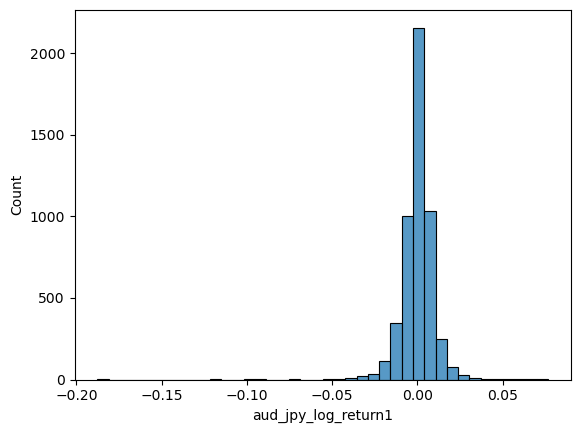

In [48]:
# Extreme values checks

sns.histplot(df['aud_jpy_log_return1'], bins=40) # Shows extreme values

##### Left-skewed distribution for AUDJPY daily log returns. Outliers that may be exogenous-shock related.

<Axes: xlabel='stock_idx_log_return1', ylabel='Count'>

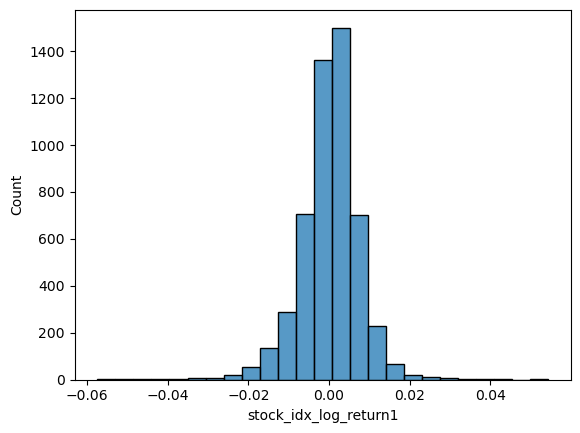

In [54]:
# Extreme values checks

sns.histplot(df['stock_idx_log_return1'], bins=25) # Shows extreme values

##### Normal-looking distribution for the Australian stock index daily log returns.

In [63]:
# Check the summary statistics for the two daily log return variables
df[['stock_idx_log_return1', 'aud_jpy_log_return1']].describe()

,stock_idx_log_return1,aud_jpy_log_return1
count,5120.000000,5120.000000
mean,0.000130,0.000031
std,0.007371,0.009607
min,-0.057497,-0.187704
25%,-0.003547,-0.003873
50%,0.000614,0.000465
75%,0.004150,0.004487
max,0.054371,0.076730


#### Checking the minimum value for 'aud_jpy_log_return1' against historical FX (foreign exchange) cross-rate records, there was in fact a sharp waterfall-like decline for AUDJPY from July 2008 through December 2008.  Thus, outlier data values around that time (during the Global Financial Crisis) were likely accurate records.  Meanwhile, the other figures in the summary statistics table above look reasonable.

In [361]:
# Check the correlation coefficient of the two variables

df['stock_idx_log_return1'].corr(df['aud_jpy_log_return1'])

0.322564045839252

##### Comment: That is quite a drop from the +0.77 correlation coefficient for the annual log returns dataset!

### 05. Data prep for regression analysis

#### Run two scatterplots, swapping the two variables to see how they plot against each other.  Either variable could serve as the independent or dependent variable, based on real-world connected relationships between stock market indices and foreign exchange rates. Incorporate a shock-related categorical variable overlay to visually inspect the impact of exogenous shocks on outlier data points.

In [73]:
df.columns

Index(['timestamp', 'stock_index', 'aud_jpy', 'stock_idx_log_return1',
       'aud_jpy_log_return1', 'shock_name'],
      dtype='object')

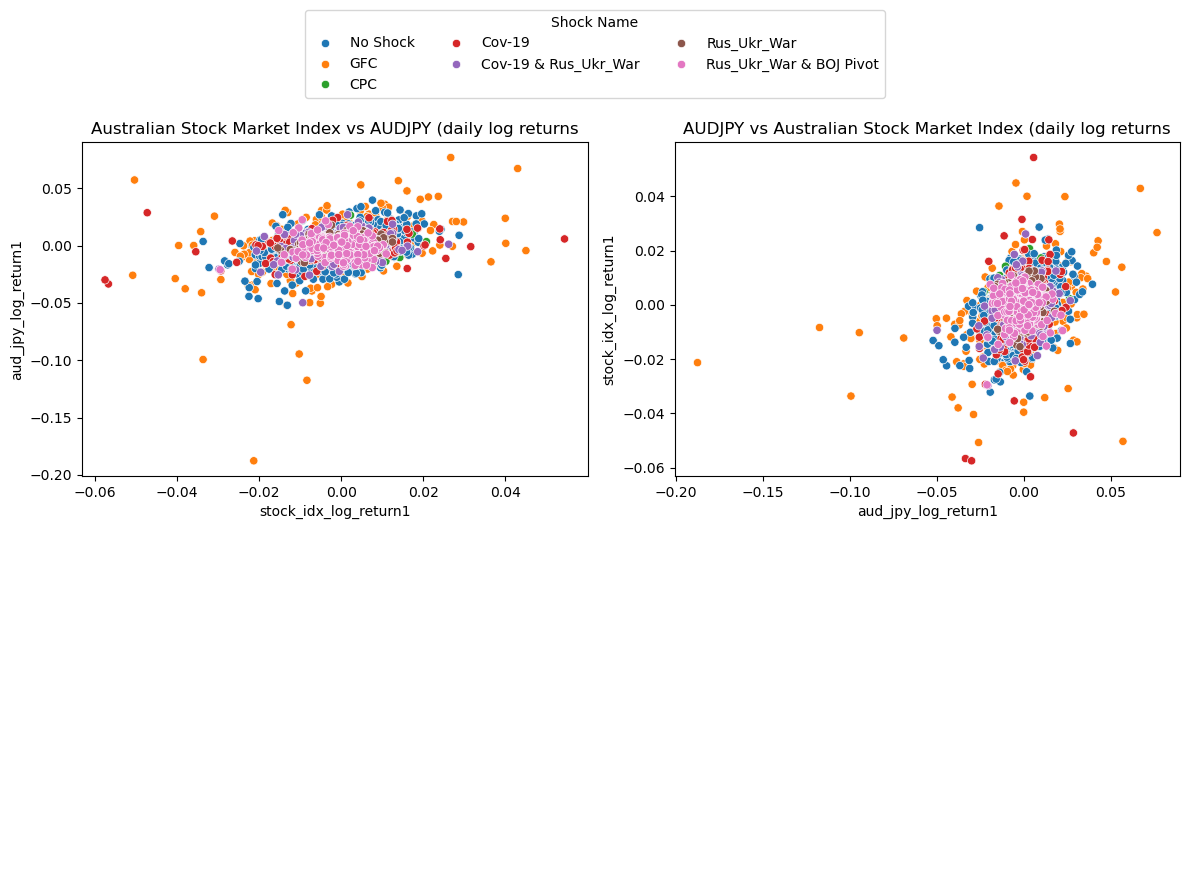

In [93]:
# Create a 1 x 2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_kwargs = dict(data=df, hue='shock_name', legend=False)

# Create scatterplots without individual legends
sns.scatterplot(x='stock_idx_log_return1', y='aud_jpy_log_return1', ax=axes[0, 0], **plot_kwargs)
axes[0, 0].set_title('Australian Stock Market Index vs AUDJPY (daily log returns')

sns.scatterplot(x='aud_jpy_log_return1', y='stock_idx_log_return1', ax=axes[0, 1], **plot_kwargs)
axes[0, 1].set_title('AUDJPY vs Australian Stock Market Index (daily log returns')

# Turn off empty subplot
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# Create a dummy plot to extract legend handles and labels
dummy_fig, dummy_ax = plt.subplots()
dummy_plot = sns.scatterplot(x='stock_idx_log_return1', y='aud_jpy_log_return1', hue='shock_name', data=df, ax=dummy_ax)
handles, labels = dummy_ax.get_legend_handles_labels()
plt.close(dummy_fig)  # Close dummy plot so it doesn't show

# Add single legend to the full grid
fig.legend(handles, labels, title='Shock Name', loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save figure as a high-resolution image
path = r'C:\Users\dirk8\CareerFoundry Projects\05-2025 Exogenous Shocks Analysis'
fig.savefig(os.path.join(path, 'Analysis', 'Visualizations', 'ASX_vs_AUDJPY_scat_daily.png'), dpi=300, bbox_inches='tight')

plt.show()

### A disproportionate share of the outliers occurred during the Global Financial Crisis (orange dots) and Covid-19 era (red dots). The other exogenous shocks do not appear to have created outliers. Visually speaking, the outliers in the scatterplot will likely cause problems for a linear function-based fit to the data.

### Define a custom function to create a grid of histograms for selected variables, with a categorical variable overlay

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def shockstack_grid(df, vars_to_plot, hue='shock_name', bins=20, cols=3, figsize_per_plot=(6, 5),
                     save=False, filename=None, filetype='png', output_dir='.'):
    """
    Plots a grid of color-stacked histograms for selected variables using the 'hue' column (default: 'shock_name').

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        vars_to_plot (list of str): List of up to 9 numeric variable names to include.
        hue (str): Column name to use for stacked colors (e.g., 'shock_name').
        bins (int): Number of bins for histogram.
        cols (int): Number of columns in the subplot grid (2 or 3 recommended).
        figsize_per_plot (tuple): Size per subplot (width, height).
        save (bool): If True, saves to disk.
        filename (str): If "save" chosen, specify the filename for the output.
        filetype (str) : If "save" chosen, optional other formats include 'pdf', otherwise defaults to 'png'.
        output_dir (str): Path where figures are saved.
    """
    num_vars = len(vars_to_plot)
    rows = math.ceil(num_vars / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_plot[0] * cols, figsize_per_plot[1] * rows), constrained_layout=True)
    axes = axes.flatten() if num_vars > 1 else [axes]
    
    # Define color palette
    categories = df[hue].dropna().unique()
    palette = sns.color_palette("tab10", len(categories))
    color_dict = dict(zip(categories, palette))
    
    for i, var in enumerate(vars_to_plot):
        ax = axes[i]
        # Drop NA rows for variable and hue
        sub_df = df[[var, hue]].dropna()

        # Create binned intervals
        bin_counts = pd.cut(sub_df[var], bins=bins)
        
        # Cross-tabulate
        ctab = pd.crosstab(bin_counts, sub_df[hue])

        # Ensure consistent order
        ctab = ctab[categories]  # match hue order to color_dict

        # Plot stacked bar
        ctab.plot(kind='bar', stacked=True, ax=ax, color=[color_dict[c] for c in categories], edgecolor='black', linewidth=0.3, legend=False)

        ax.set_title(var, fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', labelrotation=45)

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Central legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[c]) for c in categories]
    fig.legend(handles, categories, title=hue, loc='upper right', bbox_to_anchor=(0.97, 1.25), fontsize=8)
    
    plt.suptitle("Stacked Histograms by Shock Event", fontsize=14)

    if save:
        if filename is None:
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            filename = f"shockstack_grid_{timestamp}.{filetype}"
        else:
            filename = f"{filename}.{filetype}" if not filename.endswith(f".{filetype}") else filename

        full_path = os.path.join(output_dir, filename)
        plt.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved to: {full_path}")
    
    plt.show()


✅ Saved to: C:\Users\dirk8\CareerFoundry Projects\05-2025 Exogenous Shocks Analysis\Analysis\Visualizations\asx_audjpy_hist.png


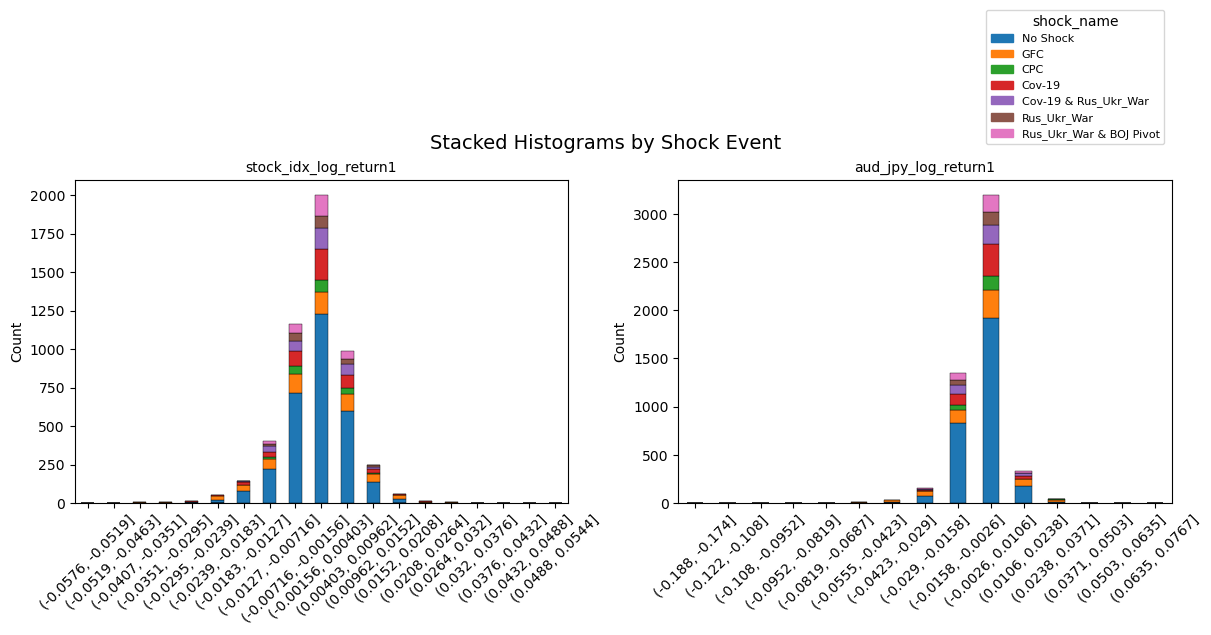

In [125]:
asx_audjpy_scat_vars = ['stock_idx_log_return1', 'aud_jpy_log_return1']

shockstack_grid(df=df, vars_to_plot=asx_audjpy_scat_vars, hue='shock_name', bins=20, cols=2, save=True, filename='asx_audjpy_hist',\
                output_dir=r'C:\Users\dirk8\CareerFoundry Projects\05-2025 Exogenous Shocks Analysis\Analysis\Visualizations')

#### Both histograms suggest that the outliers have very low frequency counts relative to the Modal range count.  It will be interesting to see how these outliers impact a linear function line fit, shortly.

### A country's foreign exchange rates and its stock market are connected, but respond to many different variables.  Which variable might serve as the independent or dependent variable in a correlation analysis is really a coin toss.  Any correlation present does not determine causality.  Generally, a rising stock market impacts investor confidence and capital flows, which can affect demand for a currency.  Meanwhile, an increasing local currency exchange rate against a basket of foreign currencies or a particular foreign currency, will impact the international export and import-related financial results of its companies, consumer purchases of foreign products and services, international travel, and so on. The onion has innumerable layers. One might assume that a country's stock market and currency respond similarly to positive and negative forces or stimuli, such that what's good for one is good for the other. Based on that assumption, one would expect a positive correlation between a stock market and its local currency (as the base in an FX pair) log returns. This project's prior Task 6.2 found a +0.77 positive correlation for the Australian stock market vs AUDJPY log returns, but that preliminary finding was based on a small sample size of only 231 data pairs (due to the year/month data "grain" over 19+ years). In this Task 6.4, by using a finer data "grain" (daily log returns, rather than monthly) which results in 5,120 data pairs, holding such microscope to the data is expected to reduce the magnitude of the +0.77 positive correlation to a smaller number due to the level of daily "noise" in market phenomena, including but not limited to short-term sentiment shifts, intraday flows, and news releases.

### Data prep: Reshape the two variables into NumPy arrays and put them into separate objects.

In [150]:
X = df['stock_idx_log_return1'].values.reshape(-1,1)
y = df['aud_jpy_log_return1'].values.reshape(-1,1)

In [152]:
# Inspect a few values of X
X[0:3]

array([[-0.004742],
       [-0.002355],
       [ 0.008229]])

In [154]:
# Inspect a few values of y
y[0:3]

array([[ 0.000103],
       [-0.004135],
       [-0.000197]])

In [162]:
# Check array length
len(X)

5120

In [164]:
# Check array length
len(y)

5120

In [166]:
# Split data into a training set and a test set.
# Use the test_size argument to create a 70/30 training/test split of the 5,120 data pairs.
# Set random_state argument to a specific integer (zero, here) to ensure reproducibility ...
# ... of the train_test_split() function's shuffling of the data before splitting into training and testing sets.
# This ensures that the same data points are included in the training and test sets every time the code is run.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

##### Check length of the training and test set NumPy arrays

In [180]:
len(X_train)

3584

In [182]:
len(X_test)

1536

In [184]:
len(y_train)

3584

In [186]:
len(y_test)

1536

### 06. Null hypothesis

### Null hypothesis: "The Australian stock market index (ASX 200) has no material relationship with the AUDJPY cross-currency rate."

### 07. Regression analysis

In [170]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [191]:
# Fit the regression object onto the training set.
# This step fits the model created to the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [193]:
# Now, create a prediction for y on the test set, since the model has been trained on the training set.
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

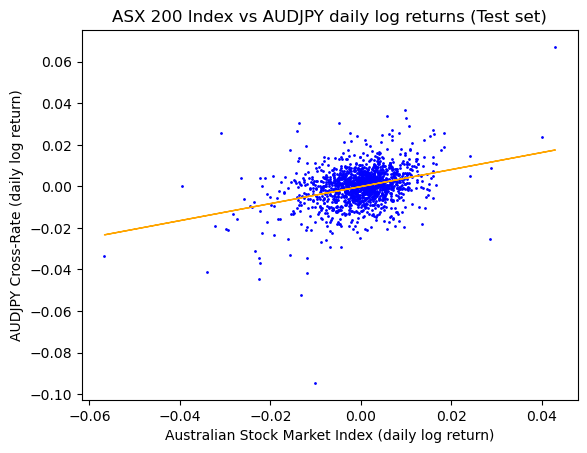

In [233]:
# Create a plot that shows the resulting linear regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='blue', s = 1)
plot_test.plot(X_test, y_predicted, color='orange', linewidth =1)
plot_test.title('ASX 200 Index vs AUDJPY daily log returns (Test set)')
plot_test.xlabel('Australian Stock Market Index (daily log return)')
plot_test.ylabel('AUDJPY Cross-Rate (daily log return)')
plot_test.show()

#### The data appears to have a proportionally-wide and changing variance around the line of best fit, including the presence of outliers that we know from a prior scatterplot to be (mostly) exogenous shock-related, specifically the reprehensible GFC and Covid-19 eras.  As expected, there is some positive correlation between ASX 200 performance and AUDJPY movement, both measured via log returns. Since the measure scale is daily log returns, the values are predictably small. The slope of the line of best fit predicts that the AUDJPY log return will change gradually per unit change of the stock market index log return.  The slope does not measure the strength of any correlation between the variables.

#### Regression model result analysis

In [241]:
# Create objects that contain the model summary statistics.

from sklearn.metrics import root_mean_squared_error # We want this function's output as well, thus need to import.

mse = mean_squared_error(y_test, y_predicted) # This is the mean squared error.
rmse = root_mean_squared_error(y_test, y_predicted) # This is the root mean squared error, easier to interpret (matches the target variable units).
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [243]:
# Print the model summary statistics.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', mse)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.4099197]]
Mean squared error:  7.186946291873405e-05
Root mean squared error:  0.008477585913379708
R2 score:  0.1282235777709665


#### Interpretation: The slope of the line of best fit predicts that for every 1-unit increase in the ASX 200 daily log return, the AUDJPY log return increases on average by 0.4099 (rounded) units.  While the mean squared error gives us the average of the squared difference between predicted and actual y-values (the dependent variable), the root mean squared error is easier to interpret because it gives us the average prediction error size in the same units as the y-variable, where comparisons are simpler.  Since most of the log return actual values fall within range endpoints between -0.02 and +0.02 (bulk data zone), a root mean squared error of 0.0085 (rounded) is ~ less than half the "width" of the bulk data zone). In the context of daily log returns, which experience a lot of "noise", that is not a large error from a relative magnitude perspective, but it is not small either.  We might call it "moderate" in size.  However, the R2 score (coefficient of determination) is very low.  It tells us that only 12.8% (rounded) of the variance in AUDJPY daily log returns is explained by the ASX 200 daily log returns.  The implication is that many other variables, not examined or modeled here, also impact AUDJPY daily log returns.  This single-variable linear regression model result is expected for daily financial time series, which are by nature "noisy" and subject to shocks of varying size and duration. If we were to swap the variables' independent vs dependent designations and study AUDJPY impact on the Australian Stock Market daily log returns, we would expect the exact same result. Based on visual analysis of the scatterplot above, outliers likely did not affect the root mean square error or R2 score that much.  They were sparse, relative to the dense pack of data pairs in the bulk data zone and not that distant from that zone.

#### Conclusion: the null hypothesis stated earlier cannot be rejected by the daily log return-level data.

#### Plotting the residuals helps us decide whether errors appear random or follow a pattern.

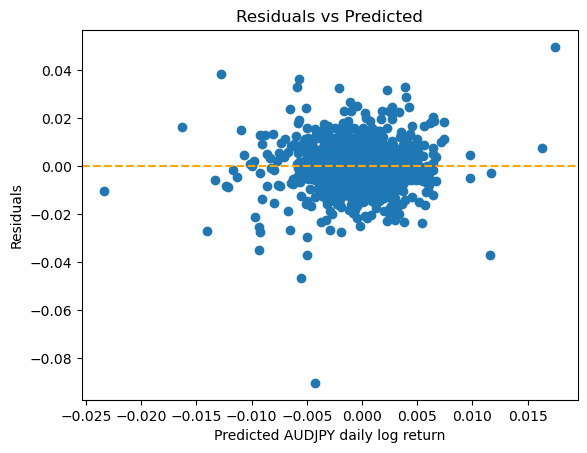

In [368]:
# Plot the residuals

residuals = y_test - y_predicted
plt.scatter(y_predicted, residuals)
plt.axhline(y=0, color='orange', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted AUDJPY daily log return")
plt.ylabel("Residuals")
plt.show()

##### These (above) appear random.

In [382]:
# Comparing the actual y-values with the predicted y-values in a dataframe, showing the first 10 values.
data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(10)

,Actual,Predicted
0,0.009337,0.001643
1,-0.007261,-0.000814
2,-0.003249,-0.000421
3,-0.001944,-0.002360
4,0.013337,0.001464
5,0.004877,0.000434
6,0.004482,0.001616
7,-0.009664,-0.007999
8,-0.005278,-0.004079
9,0.012323,0.004920


### 08. Regression fit to a longer cycle temporal dataset for comparison

#### For comparison, it's useful to run a linear regression on the project's Australia-filtered monthly temporal dataset for the two variables. The monthly data value for each variable is an average of that month's daily values. This has a smoothing effect on data patterns, at the expense of far fewer data points which detracts from the robustness of a regression analysis.

#### Import dataset and verify import results

In [285]:
path = r'C:\Users\dirk8\CareerFoundry Projects\05-2025 Exogenous Shocks Analysis'

In [287]:
df2 = pd.read_pickle(os.path.join(path, 'Data', 'Prepared Data', 'australia_cat_pre_stat.pkl'))

In [289]:
# Check the dimensions
df2.shape

(231, 17)

In [291]:
# Check the first 3 rows
df2.head(3)

,int_rate_ovn_diff,int_rate_3m_diff,int_rate_10y_diff,stock_index_logret12,gdp_pc_usd_logret12,real_gdp_chg_pct_logret12,unemp_rate_logret12,population_pct_chg,vix_avg_logret12,aud_cad_logret12,aud_jpy_logret12,chf_aud_logret12,eur_aud_logret12,gbp_aud_logret12,usd_aud_logret12,gold_oz_usd_logret12,shock_name
0,0.0025,0.0021,-0.0015,0.174791,0.046371,0.025668,0.017596,0.013586,-0.110001,-0.066691,0.100485,-0.074108,-0.071459,-0.041500,0.022642,0.259859,No Shock
1,0.0025,-0.0002,-0.0013,0.160289,0.046371,0.025668,0.003929,0.013586,0.062883,-0.132060,0.064805,-0.038100,-0.030583,-0.020965,0.053245,0.270769,No Shock
2,0.0001,-0.0020,-0.0031,0.170582,0.046371,0.025668,-0.057843,0.013586,-0.116166,-0.133531,0.032516,-0.028171,-0.018019,-0.012423,0.075794,0.250028,No Shock


In [293]:
# Check the last 3 rows
df2.tail(3)

,int_rate_ovn_diff,int_rate_3m_diff,int_rate_10y_diff,stock_index_logret12,gdp_pc_usd_logret12,real_gdp_chg_pct_logret12,unemp_rate_logret12,population_pct_chg,vix_avg_logret12,aud_cad_logret12,aud_jpy_logret12,chf_aud_logret12,eur_aud_logret12,gbp_aud_logret12,usd_aud_logret12,gold_oz_usd_logret12,shock_name
228,0.0000,-0.0002,0.0033,0.103963,-0.026012,0.015873,0.007326,0.013204,0.224487,0.011173,0.004112,0.011364,0.012121,0.035994,0.064125,0.286810,Rus_Ukr_War & BOJ Pivot
229,-0.0010,-0.0017,0.0028,0.096376,-0.026012,0.015873,0.082309,0.013204,0.193819,0.022473,-0.020073,0.005698,0.000000,0.025447,0.038466,0.358192,Rus_Ukr_War & BOJ Pivot
230,-0.0025,-0.0023,0.0038,0.024064,-0.026012,0.015873,0.048050,0.013204,0.459799,0.011173,-0.045619,0.045462,0.035507,0.055152,0.038466,0.323844,Rus_Ukr_War & BOJ Pivot


In [295]:
# Check variable names in a convenient format
df2.columns

Index(['int_rate_ovn_diff', 'int_rate_3m_diff', 'int_rate_10y_diff',
       'stock_index_logret12', 'gdp_pc_usd_logret12',
       'real_gdp_chg_pct_logret12', 'unemp_rate_logret12',
       'population_pct_chg', 'vix_avg_logret12', 'aud_cad_logret12',
       'aud_jpy_logret12', 'chf_aud_logret12', 'eur_aud_logret12',
       'gbp_aud_logret12', 'usd_aud_logret12', 'gold_oz_usd_logret12',
       'shock_name'],
      dtype='object')

In [300]:
# Calculate correlation coefficient for the two variables of interest to ensure these match with the same data pair correlation taken in Task 6.2
df2['stock_index_logret12'].corr(df2['aud_jpy_logret12'])

0.7670340499854943

##### It matches.

In [350]:
# Check the summary statistics for the two daily log return variables
df2[['stock_index_logret12', 'aud_jpy_logret12']].describe()

,stock_index_logret12,aud_jpy_logret12
count,231.000000,231.000000
mean,0.032530,0.008851
std,0.150373,0.123407
min,-0.583285,-0.482126
25%,-0.035461,-0.045622
50%,0.054130,0.020192
75%,0.129170,0.084398
max,0.353071,0.306610


#### These variables measure the 12-month (annual) log returns, thus the numbers are much larger than for the daily log returns data.  The Global Financial Crisis really did have an enormous downside impact on the variables, as shown in the next scatterplot with a categorical variable overlay. None of the statistics in the table appear questionable.

#### Run scatterplots on the two variables, with a categorical variable overlay

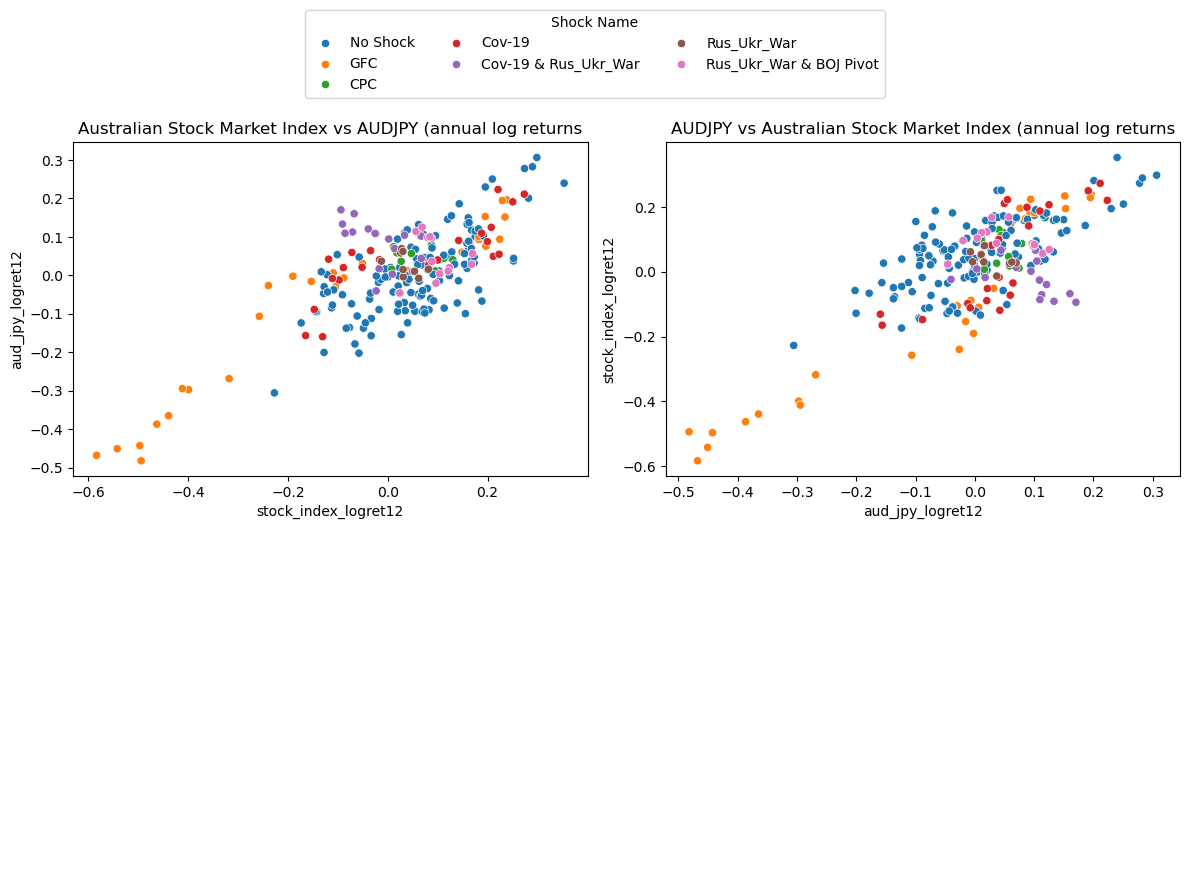

In [317]:
# Create a 1 x 2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_kwargs = dict(data=df2, hue='shock_name', legend=False)

# Create scatterplots without individual legends
sns.scatterplot(x='stock_index_logret12', y='aud_jpy_logret12', ax=axes[0, 0], **plot_kwargs)
axes[0, 0].set_title('Australian Stock Market Index vs AUDJPY (annual log returns')

sns.scatterplot(x='aud_jpy_logret12', y='stock_index_logret12', ax=axes[0, 1], **plot_kwargs)
axes[0, 1].set_title('AUDJPY vs Australian Stock Market Index (annual log returns')

# Turn off empty subplot
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# Create a dummy plot to extract legend handles and labels
dummy_fig, dummy_ax = plt.subplots()
dummy_plot = sns.scatterplot(x='stock_index_logret12', y='aud_jpy_logret12', hue='shock_name', data=df2, ax=dummy_ax)
handles, labels = dummy_ax.get_legend_handles_labels()
plt.close(dummy_fig)  # Close dummy plot so it doesn't show

# Add single legend to the full grid
fig.legend(handles, labels, title='Shock Name', loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

#### Run the custom function defined earlier to output histograms for the two variables of interest, with a categorical variable overlay

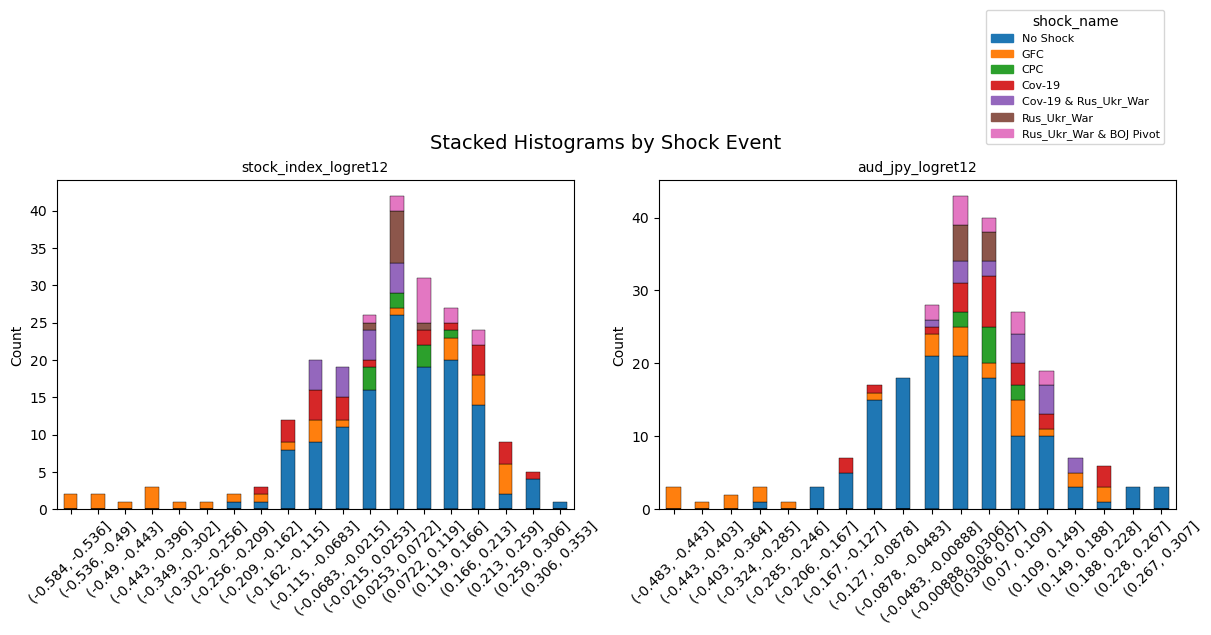

In [322]:
asx_audjpy_scat_vars2 = ['stock_index_logret12', 'aud_jpy_logret12']

shockstack_grid(df=df2, vars_to_plot=asx_audjpy_scat_vars2, hue='shock_name', bins=20, cols=2, save=False)

#### Data prep

In [303]:
# Reshape the two variables into NumPy arrays and put them into separate objects
X2 = df2['stock_index_logret12'].values.reshape(-1,1)
y2 = df2['aud_jpy_logret12'].values.reshape(-1,1)

In [305]:
# Inspect a few values of X2
X2[0:3]

array([[0.17479125],
       [0.16028879],
       [0.17058189]])

In [307]:
# Inspect a few values of y2
y2[0:3]

array([[0.10048461],
       [0.06480525],
       [0.03251641]])

In [313]:
# Check array length
len(X2)

231

In [315]:
# Check array length
len(y2)

231

In [326]:
# Split data into a training set and a test set.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=0)

##### Check length of the training and test set NumPy arrays

In [330]:
len(X2_train)

161

In [332]:
len(y2_train)

161

In [334]:
len(X2_test)

70

In [336]:
len(y2_test)

70

#### Regression analysis

In [340]:
# Create a regression object.

regression2 = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [342]:
# Fit the regression object onto the training set.
# This step fits the model created to the training set.

regression2.fit(X2_train, y2_train)

LinearRegression()

In [344]:
# Now, create a prediction for y2 on the test set, since the model has been trained on the training set.
# Predict the values of y2 using X2.

y2_predicted = regression2.predict(X2_test)

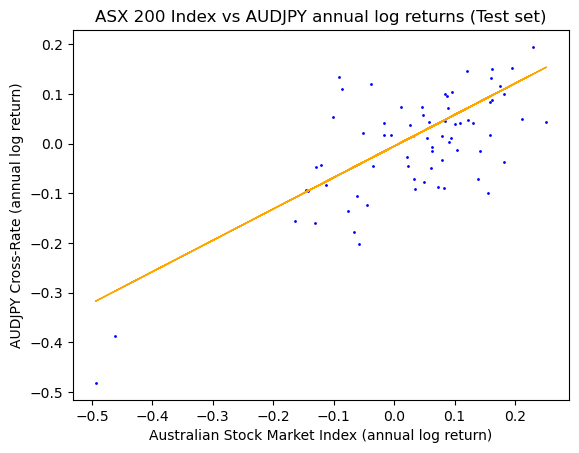

In [346]:
# Create a plot that shows the resulting linear regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X2_test, y2_test, color='blue', s = 1)
plot_test.plot(X2_test, y2_predicted, color='orange', linewidth =1)
plot_test.title('ASX 200 Index vs AUDJPY annual log returns (Test set)')
plot_test.xlabel('Australian Stock Market Index (annual log return)')
plot_test.ylabel('AUDJPY Cross-Rate (annual log return)')
plot_test.show()

#### As before, but based on far fewer data points, there is proportionally-wide and changing variance around the line of best fit. Visually speaking, not much improvement vis-a-vis the daily log return dataset.

In [357]:
# Create objects that contain the model summary statistics.

from sklearn.metrics import root_mean_squared_error # We want this function's output as well, thus need to import.

mse_2 = mean_squared_error(y2_test, y2_predicted) # This is the mean squared error.
rmse_2 = root_mean_squared_error(y2_test, y2_predicted) # This is the root mean squared error, easier to interpret (matches the target variable units).
r2_2 = r2_score(y2_test, y2_predicted) # This is the R2 score. 

In [359]:
# Print the model summary statistics.

print('Slope:' ,regression2.coef_)
print('Mean squared error: ', mse_2)
print('Root mean squared error: ', rmse_2)
print('R2 score: ', r2_2)

Slope: [[0.63226693]]
Mean squared error:  0.006701118704583239
Root mean squared error:  0.081860361009363
R2 score:  0.4867819722400163


#### Interpretation: The slope of the line of best fit predicts that for every 1-unit increase in the ASX 200 daily log return, the AUDJPY log return increases on average by 0.63 (rounded) units.  Steeper best-fit line for these annual log returns (which roll, e.g. update, on a monthly cycle) than for the daily log returns. The root mean squared error of 0.082 (rounded) is ~ 1/4 (one-quarter) of the range (~0.3-0.4) of the bulk data "box". For finance, this is reasonable for a 1-factor model on macro time series data. The R2 score (coefficient of determination) of 0.487 (rounded) is moderate, and substantially higher than the 0.128 score for daily log returns.  This is due to less "noise" and volatility inherent in an aggregated timescale and the averaging of daily data which took place at the data sources to arrive at the monthly figure for each variable.

## Takeaways

### The correlation coefficient of +0.77 for monthly cycle data (of annual log returns) for the 2 variables dropped sharply to +0.32 when a microscope was applied to the linear regression analysis by introducing daily log return data for the variables, concomitantly introducing all the "noise" inherent in daily data for financial time series.

### The RMSE (root mean squared error) as a proportion of the bulk data "box" increased with the temporal disaggregation, and the R2 score (coefficient of determination) dropped sharply, to a level where ASX 200 daily log returns explained only 12.8% of the variance in the AUDJPY daily log returns.

### The larger picture is that linear model fit to data worsens as we disaggregate temporally (apply a microscope to analyze shorter timespans), at least for financial time series data which are heavily subject to "noise".

### AUDJPY, the dependent variable in this analysis segment, is influenced by many, many real world variables, as is the ASX 200.  A 1-factor linear regression model for financial time series data will never reach a high R2 score for daily log return data. Outside research suggests that the best 1-factor models in finance rarely achieve an R2 score > 0.3 for daily log returns.  Such is the reality and bane of "noise".

### The goal here was to understand how much of AUDJPY's daily log return variance can be explained by ASX 200 daily log returns alone.  Not to look for causality, this is not a causal model. More of a directional co-movement analysis.

### Temporal aggregation of data (and corresponding reduction of data points) engendered a misleadingly strong correlation coefficient, which disappeared on temporal disaggregation.

### Data bias occurred at the monthly cycle (rolling, of annual log returns) aggregation level, due to insufficient data pairs for a robust linear regression analysis, and the smoothing effect of averaging daily data into a single monthly figure.